<img src=https://littleml.files.wordpress.com/2016/09/stadsdelen-amsterdam.png width = 500 align="left">
<h1 align=center><font size=5>AMSTERDAM<br><br>NEIGHBORHOODS</font></h1>
<h2 align=center><font size=4>-</font></h2>
<h2 align=center><font size=4>July 2020</font></h2>
<h2 align=center><font size=4><a href="https://www.linkedin.com/in/dgallo88/">Daniel Gallo Sánchez</a></font></h2>


## Table of Contents

<div style="margin-top: 20px">

<font size = 3>
 
1. <a href="#item1">Introduction</a>  
    1.1. <a href="#item1.1">Business Problem</a>

2. <a href="#item2">Data</a>  
    2.1. <a href="#item2.1">Download and Explore Dataset</a>  
    2.2. <a href="#item2.2">Dealing with missing data</a>   

3. <a href="#item3">Methodology</a>  
    3.1. <a href="#item3.1">Explore Neighborhoods in Amsterdam</a>      
    3.2. <a href="#item3.2">Analyze Each Neighborhood</a>  
    3.3. <a href="#item3.3">Cluster Neighborhoods</a>  

4. <a href="#item4">Results</a>
    
5. <a href="#item5">Discussion</a>

6. <a href="#item6">Conclusion</a> 
    

</font>
</div>

<a id='item1'></a>

## 1. Introduction

As an expat living in Amsterdam, *I* would like to get insights in its neighborhoods.  People often asked me what are the coolest areas or the best neighborhoods. But my answer always starts with: “It depends what you are looking for.” Amsterdam has 101 different boroughs. 

For those *expats*, I am set to mine Amsterdam’s neighborhoods information and cluster its neighborhoods based on their similarity and features. In this way, I give other expats a set of neighborhoods together with its features; for instance, what places are more or less popular. In other words, if you like coffee shops, restaurants or shopping, I could recommend you to check these neighborhoods. On the other hand, if you like museums, movies, parks, maybe you should go to these boroughs. 

Moreover, this information might provide you (*Amsterdam citizen*) valuable insights about similar neighborhoods to the one you live now. Let’s say you want to live in another borough but very similar to the one you are living at the moment. Or the other way around, you would like to live in a different surrounding. Or maybe, you already has a restaurant and would like to open another one in a very similar environment. What area do you choose?


And last but not least, *Amsterdam Municipality* might use the result of this research to understand better the current situation of its neighborhoods. For instance, let’s assume they want to open a coffee shop in an area that it is already full of coffee shops; typical problems coming along with coffee shops might boost. It might be a better idea to open the coffee shop in a different borough, in order not to concentrate the problem in one place but to spread it and soften its effects overall.

<a id='item1.1'></a>

### Business Question:
In this research, using a data-driven approach, I will segment and cluster Amsterdam neighborhoods based on their similarities and show their top 10 most common places. What Neighborhoods in Amsterdam are similar?  

Main Stakeholders:
-	Myself
-	Expats
-	Amsterdam citizens
-	Amsterdam municipality

Let’s data-discover Amsterdam!

<a id='item2'></a>

## 2. Data

The stating source of data will be the name of the neighborhoods of Amsterdam. I will get their names from: https://www.amsterdam.nl/en/districts/.
Amsterdam has

Another source of information it will be Foursquare, which is a location data provider; essentially, to explore a geographical location, and to get popular venues around a location. 
To utilize Foursquare location data, we need to pass the latitude and the longitude coordinates of the Amsterdam neighborhoods. To obtain this, we will use Nominatim, a module to convert an address into latitude and longitude values from Geopy. Geopy is a Python client/library for several popular geocoding web services. It makes it easy for Python developers to locate the coordinates of addresses, cities, countries, and landmarks across the globe using third-party geocoders and other data sources. 

<img src=https://raw.githubusercontent.com/dgallo88/Amsterdam_Neighborhoods/master/images/Geopy%20Geocoding%20Services.png width = 500 align="left">

<a id='item2.1'></a>

### 2.1 Download and Explore Dataset

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported!!!')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: d

In order to segement Amsterdam neighborhoods and explore them, we will essentially need a dataset that contains the name of these neighborhoods as well as the the latitude and logitude coordinates of each neighborhood. Luckily, this information exists for free on the web at:  
https://www.amsterdam.nl/en/districts/  

Amsterdam is divided into *7 districts* and each district is divided into neighbourhoods. Amsterdam has *26 neighbourhoods* in total.

I put the name of the neighborhoods in an Excel documents and upload the file to GitHub. Another option it would be to use Postal Codes, but doing this analysis with the names of the neighborhoods is more comprenhensive. Let's have a look at Amsterdam districts and neighboorhoods. 

In [2]:
neighborhoods_data = pd.read_excel('https://github.com/dgallo88/Amsterdam_Neighborhoods/raw/master/Amsterdam_Districts_and_Neighborhoods.xlsx')
neighborhoods_data

,District,Neighborhood
0,Centre,Centrum-Oost
1,Centre,Centrum-West
2,West,De Baarsjes
3,West,Oud-West
4,West,Westerpark
5,West,Bos en Lommer
6,Nieuw-West,Geuzenveld
7,Nieuw-West,Slotermeer
8,Nieuw-West,Sloterdijken
9,Nieuw-West,Slotervaart


Let's check the type of the data.

In [3]:
print (neighborhoods_data.dtypes)

District        object
Neighborhood    object
dtype: object


The type in the data frame is an *object*, let's change it to *string* for our own convenience later on. 

In [4]:
neighborhoods_data[["District"]] = neighborhoods_data[["District"]].astype('string')
neighborhoods_data[["Neighborhood"]] = neighborhoods_data[["Neighborhood"]].astype('string')
print (neighborhoods_data.dtypes)

District        string
Neighborhood    string
dtype: object


Now that we have built a dataframe of the districts and neighborhood names, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. We will use the *geopy* library for this purpuse.

In order to define an instance of the geocoder, we need to define a *user_agent*. We will name our agent *ams_explorer*, as shown below.

In [5]:
neighborhoods =  pd.DataFrame(columns=['District','Neighborhood', 'Latitude', 'Longitude'])
geolocator = Nominatim(user_agent='ams_explorer')

for index, row in neighborhoods_data.iterrows():
    district_name = row['District']
    neighborhood_name = row['Neighborhood']
    address = neighborhood_name + ', Amsterdam, Noord-Holland, Nederland'  
    location = geolocator.geocode(address)
    if location is None:
        latitude = None
        longitude = None
    else:
        latitude = location.latitude
        longitude = location.longitude
    neighborhoods = neighborhoods.append({'District': district_name,'Neighborhood': str(neighborhood_name), 'Latitude': latitude, 'Longitude': longitude}, ignore_index=True)
    print('{}: {}'.format(index, neighborhood_name))
    print('location: {}'.format(location))
    print('{}: {}, {}.'.format('coordinates: ', latitude, longitude)) 

0: Centrum-Oost
location: CWI, Science Park, Watergraafsmeer, Amsterdam, Noord-Holland, Nederland, 1098 XG, Nederland
coordinates: : 52.356509700000004, 4.952102635783275.
1: Centrum-West
location: Centrum, Amsterdam, Noord-Holland, Nederland, 1012JK, Nederland
coordinates: : 52.3737301, 4.8956908.
2: De Baarsjes
location: De Baarsjes, Amsterdam, Noord-Holland, Nederland, 1057WX, Nederland
coordinates: : 52.3689257, 4.8563825.
3: Oud-West
location: Oud-West, Amsterdam, Noord-Holland, Nederland
coordinates: : 52.36481465, 4.869761930307041.
4: Westerpark
location: Westerpark, Amsterdam, Noord-Holland, Nederland
coordinates: : 52.387236349999995, 4.871777328438663.
5: Bos en Lommer
location: Bos en Lommer, Amsterdam, Noord-Holland, Nederland, 1055DZ, Nederland
coordinates: : 52.3785206, 4.8487385.
6: Geuzenveld
location: Geuzenveld, Amsterdam, Noord-Holland, Nederland, 1067JR, Nederland
coordinates: : 52.3783939, 4.8016275.
7: Slotermeer
location: Slotermeer, Amsterdam, Noord-Holland, Ne

In [6]:
neighborhoods

,District,Neighborhood,Latitude,Longitude
0,Centre,Centrum-Oost,52.356510,4.952103
1,Centre,Centrum-West,52.373730,4.895691
2,West,De Baarsjes,52.368926,4.856382
3,West,Oud-West,52.364815,4.869762
4,West,Westerpark,52.387236,4.871777
5,West,Bos en Lommer,52.378521,4.848738
6,Nieuw-West,Geuzenveld,52.378394,4.801628
7,Nieuw-West,Slotermeer,52.377961,4.821952
8,Nieuw-West,Sloterdijken,NaN,NaN
9,Nieuw-West,Slotervaart,52.361286,4.827466


<a id='item2.2'></a>

### 2.2 Dealing with missing data

Let's see how many elemens in the data frame are with *Latitude* and *Longitude* equal to *NaN*

In [8]:
null_values_df = neighborhoods[neighborhoods['Latitude'].isnull().values]
null_values_df

,District,Neighborhood,Latitude,Longitude
8,Nieuw-West,Sloterdijken,NaN,NaN
31,Oud-Noord,Noordelijke IJ-oever,NaN,NaN
35,Zuid Oost,Amstel lll,NaN,NaN
37,Zuid Oost,Bijlmer-Centrum,NaN,NaN
38,Zuid Oost,Bijlmer-Oost,NaN,NaN


In [9]:
null_values_df.shape[0]

5

There are 5 neighborhoods with empty coordinates. Nominatim (in the background Open Street Map) cannot retrieve theirs coordinates. As there are only 5 neighborhoods missing their latitude and longitude, I am going to look up those values on the internet and replace it with the right coordinates. Moreover, I am fixing 3 others coordinates to point to the center of those 3 neighborhoods.

In [10]:
neighborhoods.loc[neighborhoods['Neighborhood']=='Sloterdijken', ['Latitude', 'Longitude']] = [52.3871,4.8465] 
neighborhoods.loc[neighborhoods['Neighborhood']=='Noordelijke IJ-oever', ['Latitude', 'Longitude']] = [52.3923, 4.9014]
neighborhoods.loc[neighborhoods['Neighborhood']=='Amstel lll', ['Latitude', 'Longitude']] = [52.2952,4.9460] 
neighborhoods.loc[neighborhoods['Neighborhood']=='Bijlmer-Centrum', ['Latitude', 'Longitude']] = [52.3170,4.9650]
neighborhoods.loc[neighborhoods['Neighborhood']=='Bijlmer-Oost', ['Latitude', 'Longitude']] = [52.3169,4.9801]

#fixing some incorrect coordinates
neighborhoods.loc[neighborhoods['Neighborhood']=='Centrum-Oost', ['Latitude', 'Longitude']] = [52.36456,4.90678]
neighborhoods.loc[neighborhoods['Neighborhood']=='Waterland', ['Latitude', 'Longitude']] = [52.39345,4.99409]
neighborhoods.loc[neighborhoods['Neighborhood']=='Oud-Oost', ['Latitude', 'Longitude']] = [52.35999,4.92523]

neighborhoods

,District,Neighborhood,Latitude,Longitude
0,Centre,Centrum-Oost,52.364560,4.906780
1,Centre,Centrum-West,52.373730,4.895691
2,West,De Baarsjes,52.368926,4.856382
3,West,Oud-West,52.364815,4.869762
4,West,Westerpark,52.387236,4.871777
5,West,Bos en Lommer,52.378521,4.848738
6,Nieuw-West,Geuzenveld,52.378394,4.801628
7,Nieuw-West,Slotermeer,52.377961,4.821952
8,Nieuw-West,Sloterdijken,52.387100,4.846500
9,Nieuw-West,Slotervaart,52.361286,4.827466


Let's now show the neighborhoods on a map, but first we need Amsterdam coordinates.

In [11]:
address = 'Amsterdam, Noord-Holland, Nederland'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Amsterdam are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Amsterdam are 52.37454030000001, 4.897975505617977.


Let's create a map of Amsterdam with neighborhoods superimposed on top. Neighborhoods of the same color on this map belong to the same district.

In [12]:
# create map of Amsterddam using latitude and longitude values
map_ams = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the Districts
districs = neighborhoods['District'].unique()
kclusters = len(districs)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

# add markers to map
for lat, lng, district, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['District'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=500,
        popup=label,
        color=rainbow[np.where(districs==district)[0][0]],
        fill=True,
        fill_color=rainbow[np.where(districs==district)[0][0]],
        fill_opacity=0.7,
        parse_html=False).add_to(map_ams)  
    
map_ams

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective district.


<a id='item3'></a>

## 3. Methodology

In the session above, we converted Amsterdam's neighborhoods into their equivalent latitude and longitude values. In this session, I will use the *Foursquare API* to explore those neighborhoods. I will use the *explore* function to get the most common *venue categories* in each neighborhood, and then use this feature to group the neighborhoods into clusters. I will use the k-means clustering algorithm to complete this task. Finally, I will use the Folium library to visualize the neighborhoods in Amsterdam and their emerging clusters.

Next, we are going to start utilizing the **Foursquare API** to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [13]:
# @hidden_cell

CLIENT_ID = 'JMWOIVHGTJLVU0Q01P05GKLX2OCPUXINZLWVW4KYBFE3DLT0' # your Foursquare ID
CLIENT_SECRET = '01JPYMX0ECILJTS0HD232N02XDFX1TSF0WCFYTVZBUZO5GO1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JMWOIVHGTJLVU0Q01P05GKLX2OCPUXINZLWVW4KYBFE3DLT0
CLIENT_SECRET:01JPYMX0ECILJTS0HD232N02XDFX1TSF0WCFYTVZBUZO5GO1


<a id='item3.1'></a>

### 3.1 Explore Neighborhoods in Amsterdam

Let's create a function to explore all the neighborhoods in Amsterdam using the *Foursquare API*. The request to Foursquare will returns a list of recommended venues near the location of the neighborhoods. 


In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
            
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name + ':')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        print('{} {}'.format(len(results), 'venues found'))
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's now write the code to run the above function on each neighborhood and create a new dataframe called *amsterdam_venues*.

In [15]:
amsterdam_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                   radius=500,
                                   limit=100
                                   )

Centrum-Oost:
99 venues found
Centrum-West:
100 venues found
De Baarsjes:
61 venues found
Oud-West:
100 venues found
Westerpark:
48 venues found
Bos en Lommer:
48 venues found
Geuzenveld:
14 venues found
Slotermeer:
29 venues found
Sloterdijken:
12 venues found
Slotervaart:
11 venues found
De Aker:
11 venues found
Sloten:
10 venues found
Nieuw-Sloten:
6 venues found
Osdorp:
24 venues found
Buitenveldert:
49 venues found
Zuidas:
40 venues found
Rivierenbuurt:
50 venues found
De Pijp:
100 venues found
Oud-Zuid:
62 venues found
Banne Buiksloot:
10 venues found
Kadoelen:
4 venues found
Oostzanerwerf:
10 venues found
Tuindorp Oostzaan:
9 venues found
Buikslotermeer:
25 venues found
Elzenhagen:
2 venues found
Waterland:
3 venues found
Waterlandpleinbuurt:
7 venues found
Buiksloterdijk:
14 venues found
Nieuwendammerdijk:
6 venues found
Ijplein:
19 venues found
Vogelbuurt:
22 venues found
Noordelijke IJ-oever:
9 venues found
Tuindorp Buiksloot:
9 venues found
Tuindorp Nieuwendam:
6 venues foun

Let's check the size of the resulting dataframe

In [16]:
print(amsterdam_venues.shape)
amsterdam_venues.head()

(1259, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centrum-Oost,52.36456,4.90678,Zoku,52.363891,4.906723,Hotel
1,Centrum-Oost,52.36456,4.90678,Dignita Hoftuin,52.365608,4.904464,Tea Room
2,Centrum-Oost,52.36456,4.90678,HIGH STUDIOS,52.364273,4.906484,Gym / Fitness Center
3,Centrum-Oost,52.36456,4.90678,Delight Yoga,52.362259,4.905868,Yoga Studio
4,Centrum-Oost,52.36456,4.90678,De Hortus,52.366952,4.907511,Botanical Garden


For the sake of formality let's check that we do not have any duplicated place.

In [17]:
print(amsterdam_venues[amsterdam_venues.duplicated()].shape)
amsterdam_venues[amsterdam_venues.duplicated()]

(0, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


Let's check how many venues were returned for each neighborhood.

In [18]:
amsterdam_venues.groupby('Neighborhood').count().reset_index()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amstel lll,15,15,15,15,15,15
1,Banne Buiksloot,10,10,10,10,10,10
2,Bijlmer-Centrum,5,5,5,5,5,5
3,Bijlmer-Oost,6,6,6,6,6,6
4,Bos en Lommer,48,48,48,48,48,48
5,Buiksloterdijk,14,14,14,14,14,14
6,Buikslotermeer,25,25,25,25,25,25
7,Buitenveldert,49,49,49,49,49,49
8,Bullewijk,19,19,19,19,19,19
9,Centrum-Oost,99,99,99,99,99,99


Let's plot this using a histogram to see the distribution of the venues.

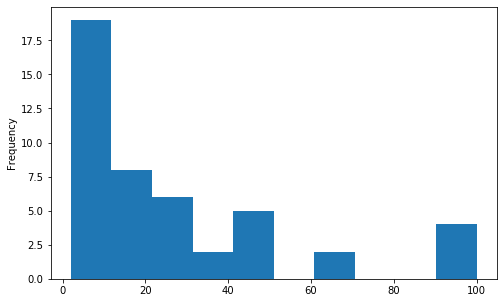

In [19]:
amsterdam_venues.groupby('Neighborhood').count()['Venue'].plot(kind='hist', figsize=(8, 5))

In [20]:
amsterdam_venues.groupby('Neighborhood').count().shape

(46, 6)

Let's find out how many unique categories can be curated from all the returned venues

In [21]:
print('There are {} uniques categories.'.format(len(amsterdam_venues['Venue Category'].unique())))
amsterdam_venues['Venue Category'].unique()

There are 236 uniques categories.


array(['Hotel', 'Tea Room', 'Gym / Fitness Center', 'Yoga Studio',
       'Botanical Garden', 'Restaurant', 'Theater', 'Art Museum',
       'Pool Hall', 'Breakfast Spot', 'Indie Movie Theater', 'Café',
       'Coworking Space', 'Bakery', 'Bar', 'Pizza Place',
       'French Restaurant', 'Plaza', 'Bistro', 'Sandwich Place',
       'History Museum', 'Beer Bar', 'Opera House', 'Greek Restaurant',
       'Science Museum', 'Smoke Shop', 'Boat or Ferry', 'Bridge',
       'Ice Cream Shop', 'Coffee Shop', 'Bagel Shop', 'Park',
       'Indonesian Restaurant', 'Burger Joint',
       'South American Restaurant', 'Marijuana Dispensary', 'Canal',
       'Japanese Restaurant', 'General Entertainment', 'Recording Studio',
       'Museum', 'Diner', 'Indoor Play Area', 'Cocktail Bar', 'Hostel',
       'Italian Restaurant', 'Supermarket', 'Snack Place',
       'Convenience Store', 'Chinese Restaurant', 'Arts & Crafts Store',
       'Steakhouse', 'Office', 'Bookstore', 'Hotel Pool', 'Liquor Store',
     

Let's see how many venues we have in each category.

In [22]:
amsterdam_venues['Venue Category'].value_counts()

Café                               57
Restaurant                         53
Coffee Shop                        51
Bar                                48
Supermarket                        41
Hotel                              41
Italian Restaurant                 35
Bakery                             34
Bus Stop                           30
Plaza                              24
Park                               23
Snack Place                        18
Pizza Place                        18
Ice Cream Shop                     17
Turkish Restaurant                 15
Drugstore                          15
Grocery Store                      15
Indonesian Restaurant              14
French Restaurant                  13
Tram Station                       12
Asian Restaurant                   12
Gym / Fitness Center               11
Chinese Restaurant                 11
Breakfast Spot                     11
Burger Joint                       11
Deli / Bodega                      10
Fast Food Re

<a id='item3.2'></a>

### 3.2 Analyze Each Neighborhood

We are going to make use of the one hot encoding to transform the dataset. Each row represents a venue in the neighborhood with 1 in the column that represent the category of the venue. The rest will be filled in with 0. 

In [23]:
# one hot encoding
amsterdam_onehot = pd.get_dummies(amsterdam_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
amsterdam_onehot['Neighborhood'] = amsterdam_venues['Neighborhood'] 

# move neighborhood column to the first column
col_name = "Neighborhood"
first_col = amsterdam_onehot.pop(col_name)
amsterdam_onehot.insert(0, col_name, first_col)

amsterdam_onehot.head()

,Neighborhood,Accessories Store,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Campground,Canal,Caribbean Restaurant,Casino,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Dairy Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hockey Field,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Latin American Restaurant,Lawyer,Lebanese Restaurant,Liquor Store,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Venue,Nightclub,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Supply Store,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rest Area,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Centrum-Oost,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Centrum-Oost,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

And let's examine the new dataframe size.

In [24]:
amsterdam_onehot.shape

(1259, 236)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category. 

In [25]:
amsterdam_grouped = amsterdam_onehot.groupby('Neighborhood').mean().reset_index()
amsterdam_grouped

,Neighborhood,Accessories Store,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Campground,Canal,Caribbean Restaurant,Casino,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Dairy Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hockey Field,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Latin American Restaurant,Lawyer,Lebanese Restaurant,Liquor Store,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Venue,Nightclub,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Supply Store,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rest Area,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Amstel lll,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.066667,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,

#### Let's confirm the new size

In [26]:
amsterdam_grouped.shape

(46, 236)

Let's print each neighborhood along with the top 10 most common venues for your reference.

In [27]:
num_top_venues = 10

for hood in amsterdam_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp = amsterdam_grouped[amsterdam_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp_ordered = temp.sort_values('freq', ascending=False).reset_index(drop=True)
    print(temp_ordered[temp_ordered['freq'] != 0.00].head(num_top_venues))
    print('\n')

---- Amstel lll ----
                    venue  freq
0  Furniture / Home Store  0.20
1              Restaurant  0.20
2               Hotel Bar  0.07
3                     Gym  0.07
4     Fried Chicken Joint  0.07
5          Sandwich Place  0.07
6    Fast Food Restaurant  0.07
7                  Bistro  0.07
8              Food Court  0.07
9                   Hotel  0.07


---- Banne Buiksloot ----
                venue  freq
0            Bus Stop   0.3
1                Park   0.2
2  Turkish Restaurant   0.1
3         Supermarket   0.1
4              Bakery   0.1
5          Restaurant   0.1
6       Shopping Mall   0.1


---- Bijlmer-Centrum ----
      venue  freq
0      Park   0.6
1  Bus Stop   0.2
2   Theater   0.2


---- Bijlmer-Oost ----
            venue  freq
0       Drugstore  0.17
1        Bus Stop  0.17
2  Discount Store  0.17
3   Shopping Mall  0.17
4     Supermarket  0.17
5          Bakery  0.17


---- Bos en Lommer ----
                           venue  freq
0                

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    row_categories_sorted.index.values[row_categories_sorted==0.0]= None   #to delete categories with frequency equals to 0
       
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = amsterdam_grouped['Neighborhood']

for ind in np.arange(amsterdam_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(amsterdam_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amstel lll,Furniture / Home Store,Restaurant,Hotel Bar,Bistro,Fried Chicken Joint,Sandwich Place,Asian Restaurant,Food Court,Hotel,Fast Food Restaurant
1,Banne Buiksloot,Bus Stop,Park,Shopping Mall,Bakery,Restaurant,Supermarket,Turkish Restaurant,None,None,None
2,Bijlmer-Centrum,Park,Bus Stop,Theater,None,None,None,None,None,None,None
3,Bijlmer-Oost,Shopping Mall,Supermarket,Bus Stop,Bakery,Discount Store,Drugstore,None,None,None,None
4,Bos en Lommer,Bakery,Restaurant,Vegetarian / Vegan Restaurant,Park,Fast Food Restaurant,Food & Drink Shop,Turkish Restaurant,Supermarket,Playground,Pizza Place
5,Buiksloterdijk,Soccer Field,Rest Area,Monument / Landmark,Park,Gym Pool,Bus Stop,Gym,Hotel,Farm,Café
6,Buikslotermeer,Electronics Store,Mobile Phone Shop,Convenience Store,Supermarket,Sporting Goods Shop,Japanese Restaurant,Restaurant,Seafood Restaurant,Drugstore,Men's Store
7,Buitenveldert,Hotel,Bakery,Drugstore,Grocery Store,Restaurant,Sandwich Place,Supermarket,Sushi Restaurant,Coffee Shop,Shopping Mall
8,Bullewijk,Hotel,Café,Restaurant,Building,Furniture / Home Store,Cafeteria,Scandinavian Restaurant,Buffet,Food & Drink Shop,Brewery
9,Centrum-Oost,Bar,Hotel,Café,Restaurant,Coffee Shop,French Restaurant,Pizza Place,Plaza,Bakery,Smoke Shop


<a id='item3.3'></a>

### 3.3. Cluster Neighborhoods

Below is the dataset that we are going to use to cluster Amsterdam neighborhoods based on the category of the most popular places.

In [30]:
amsterdam_grouped_clustering = amsterdam_grouped.drop('Neighborhood', 1)
amsterdam_grouped_clustering

,Accessories Store,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Campground,Canal,Caribbean Restaurant,Casino,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Dairy Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hockey Field,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Latin American Restaurant,Lawyer,Lebanese Restaurant,Liquor Store,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Venue,Nightclub,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Supply Store,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rest Area,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.066667,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000

The KMeans class has many parameters that can be used, but we will be using these three:
<ul>
    <li> <b>init</b>: Initialization method of the centroids. </li>
    <ul>
        <li> Value will be: "k-means++" </li>
        <li> k-means++: Selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.</li>
    </ul>
    <li> <b>n_clusters</b>: The number of clusters to form as well as the number of centroids to generate. </li>
    <li> <b>n_init</b>: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia. </li>
    <ul> <li> Value will be: 10 </li> </ul>
</ul>

But, how can we choose right value for *k*? The general solution is to run *k*-means with different values for *k*, and choose the *k* that is the best for the model. For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

In [31]:
# Best k
Ks=45
Sum_of_squared_distances =  np.zeros((Ks-1))

#Run k-means with different Ks 
for k in range(1,Ks):
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 10, random_state=0).fit(amsterdam_grouped_clustering)    
    Sum_of_squared_distances[k-1]=k_means.inertia_
    
Sum_of_squared_distances

array([4.76517225, 4.11253775, 3.76566788, 3.42500191, 3.1654468 ,
       2.98072624, 2.6674562 , 2.61692778, 2.3888381 , 2.21592088,
       2.05872112, 1.88428149, 1.7808042 , 1.66639363, 1.56886542,
       1.45823453, 1.34288544, 1.25589514, 1.16502543, 1.08903796,
       1.00291535, 0.92826077, 0.81903421, 0.75340682, 0.65363796,
       0.60058508, 0.53181356, 0.46148051, 0.4263713 , 0.38411227,
       0.33820298, 0.29343648, 0.25986796, 0.2328968 , 0.20349444,
       0.17937908, 0.15223749, 0.12786283, 0.10473307, 0.08684151,
       0.06611573, 0.04692215, 0.03134557, 0.01845077])

As k increases, the sum of squared distance tends to zero. Imagine we set k to its maximum value n (where n is number of samples) each sample will form its own cluster meaning sum of squared distances equals zero.

Below is a plot of sum of squared distances for k in the range specified above. If the plot looks like an arm, then the elbow on the arm is optimal k. For k=9, we see a very small elbow. However, to be sure, we will run a different method below.  

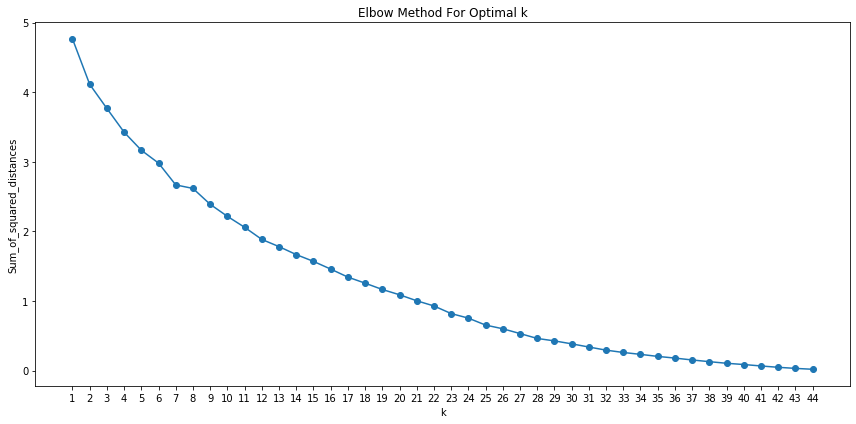

In [32]:
k= range(1,Ks)

fig = plt.figure()
fig.set_figwidth(12) # set width
fig.set_figheight(6) # set height

plt.plot(k, Sum_of_squared_distances,'o-')
plt.title('Elbow Method For Optimal k')
plt.ylabel('Sum_of_squared_distances')
plt.xlabel('k')
plt.tight_layout()
plt.xticks(k,k)
plt.show()

Let's use now the *Silhoutte Method* to determine the best value for *k*.  

The *Silhouette Coefficient* is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

[0.21473988 0.2358431  0.21278622 0.19416495 0.16620423 0.09260716
 0.09729763 0.16294931 0.09407098 0.06063734 0.09246773 0.07673333
 0.05562555 0.02595828 0.11332272 0.06995809 0.0933057  0.03753426
 0.09634488 0.12191434 0.07794788 0.0699843  0.07306415 0.11755839
 0.05489553 0.05711848 0.06190102 0.03739706 0.01575827 0.02865617
 0.01717266 0.01511519 0.01790619 0.01812818 0.00911766 0.01402996
 0.01083436 0.0133158  0.00879213 0.0131987  0.01362574 0.01321662
 0.01266929]


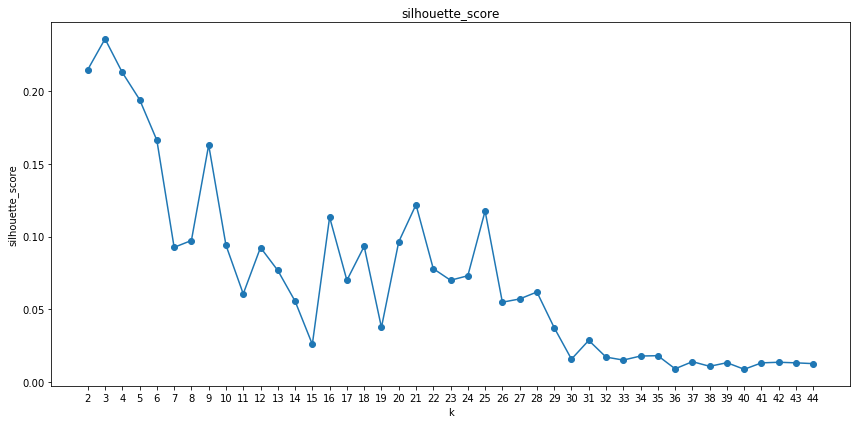

In [111]:
from sklearn.metrics import silhouette_score 

# Best k
Ks=45
silhouette_list_kmeans_elkan =  np.zeros((Ks-2))

#Run k-means with different Ks 
for k in range(2,Ks):
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 10, algorithm="elkan", random_state = 0).fit(amsterdam_grouped_clustering)    
    silhouette_list_kmeans_elkan[k-2] = silhouette_score(amsterdam_grouped_clustering, k_means.labels_)
    
print(silhouette_list_kmeans_elkan)

k= range(2,Ks)

fig = plt.figure()
fig.set_figwidth(12) # set width
fig.set_figheight(6) # set height

plt.plot(k, silhouette_list_kmeans_elkan,'o-')
plt.title('silhouette_score')
plt.ylabel('silhouette_score')
plt.xlabel('k')
plt.tight_layout()
plt.xticks(k,k)
plt.show()

Using K-Means, the best silhouette score is 0.2358431 for k=3.  

[0.21473988 0.2358431  0.21278622 0.19416495 0.16620423 0.09260716
 0.1959931  0.16294931 0.09407098 0.06063734 0.09246773 0.07673333
 0.05562555 0.02595828 0.11332272 0.06995809 0.0933057  0.03753426
 0.09634488 0.12191434 0.07794788 0.0699843  0.07306415 0.11755839
 0.05489553 0.05711848 0.06190102 0.03739706 0.01575827 0.02865617
 0.01717266 0.01511519 0.01790619 0.01812818 0.00911766 0.01402996
 0.01083436 0.0133158  0.00879213 0.0131987  0.01362574 0.01321662
 0.01266929]


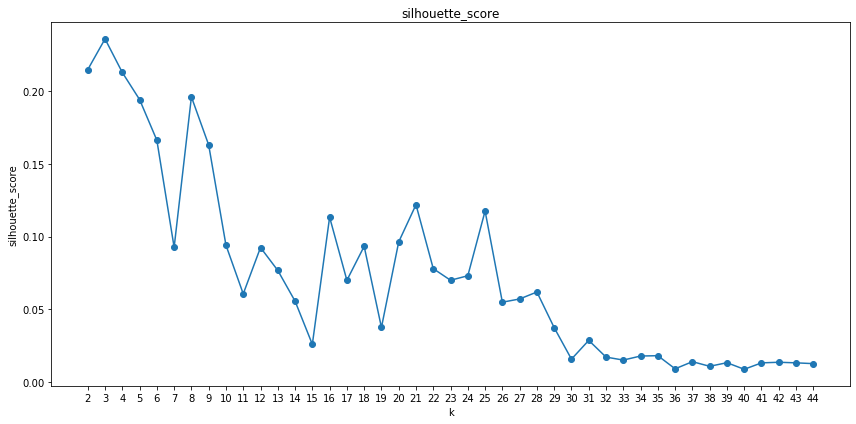

In [112]:
from sklearn.metrics import silhouette_score 

# Best k
Ks=45
silhouette_list_kmeans_full =  np.zeros((Ks-2))

#Run k-means with different Ks 
for k in range(2,Ks):
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 10, algorithm="full", random_state = 0).fit(amsterdam_grouped_clustering)    
    silhouette_list_kmeans_full[k-2] = silhouette_score(amsterdam_grouped_clustering, k_means.labels_)
    
print(silhouette_list_kmeans_full)

k= range(2,Ks)

fig = plt.figure()
fig.set_figwidth(12) # set width
fig.set_figheight(6) # set height

plt.plot(k, silhouette_list_kmeans_full,'o-')
plt.title('silhouette_score')
plt.ylabel('silhouette_score')
plt.xlabel('k')
plt.tight_layout()
plt.xticks(k,k)
plt.show()

Let's try now with **Agglomerative Clustering** we will compare all linkage {“ward”, “complete”, “average”, “single”}, default=”ward”

Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.

 - ward minimizes the variance of the clusters being merged.

 - average uses the average of the distances of each observation of the two sets.

 - complete or maximum linkage uses the maximum distances between all observations of the two sets.

 - single uses the minimum of the distances between all observations of the two sets.


[0.2024297  0.21507483 0.2225348  0.20407317 0.20916171 0.19894432
 0.20130807 0.13762127 0.14372738 0.14160595 0.13718328 0.13377956
 0.13368155 0.13537836 0.13506711 0.13535755 0.13113345 0.08106141
 0.08066081 0.0785453  0.08351189 0.08601285 0.08892377 0.08805592
 0.08436796 0.0831643  0.07796342 0.0734706  0.07578642 0.06514246
 0.02475982 0.02372054 0.02251452 0.02377348 0.02326804 0.02004691
 0.00989225 0.01172337 0.01347681 0.01463342 0.01362574 0.01321662
 0.01266929]


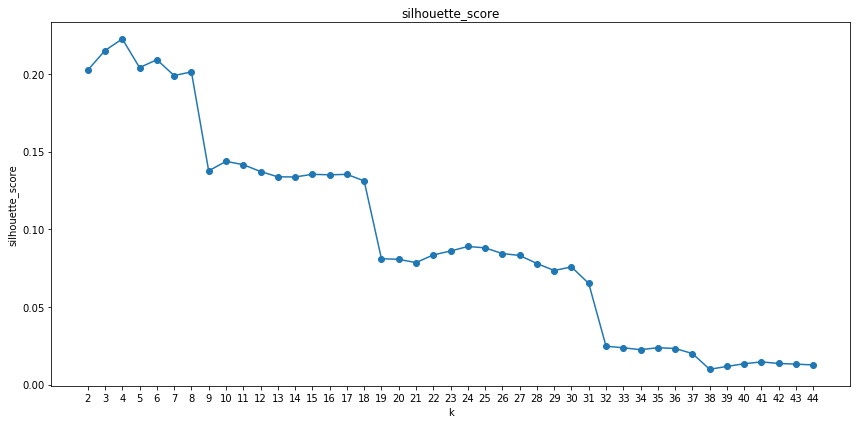

In [118]:
from sklearn.cluster import AgglomerativeClustering

# Best k
Ks=45
silhouette_list_agglomerative_ward =  np.zeros((Ks-2))

#Run k-means with different Ks 
for k in range(2,Ks):
    clusterer = AgglomerativeClustering(n_clusters = k, linkage='ward').fit(amsterdam_grouped_clustering)    
    silhouette_list_agglomerative_ward[k-2] = silhouette_score(amsterdam_grouped_clustering, clusterer.labels_)
    
print(silhouette_list_agglomerative_ward)

k= range(2,Ks)

fig = plt.figure()
fig.set_figwidth(12) # set width
fig.set_figheight(6) # set height

plt.plot(k, silhouette_list_agglomerative_ward,'o-')
plt.title('silhouette_score')
plt.ylabel('silhouette_score')
plt.xlabel('k')
plt.tight_layout()
plt.xticks(k,k)
plt.show()

Using Agglometative Clustering with linkage *ward*, the best silhouette score is 0.2225348 for k=4.

[0.41842065 0.38705653 0.34786053 0.32239178 0.24289875 0.20873767
 0.22506681 0.21541348 0.1893753  0.17925154 0.17643114 0.15212834
 0.14844337 0.1407935  0.14116925 0.11978025 0.11978494 0.11620446
 0.11812172 0.12191434 0.12229414 0.11914367 0.11833155 0.11464359
 0.09352866 0.08758607 0.0721708  0.07742192 0.07578642 0.06514246
 0.04181271 0.03415611 0.02512119 0.02331708 0.01806889 0.02028237
 0.01693769 0.01697287 0.01398216 0.01086655 0.00804207 0.01321662
 0.01266929]


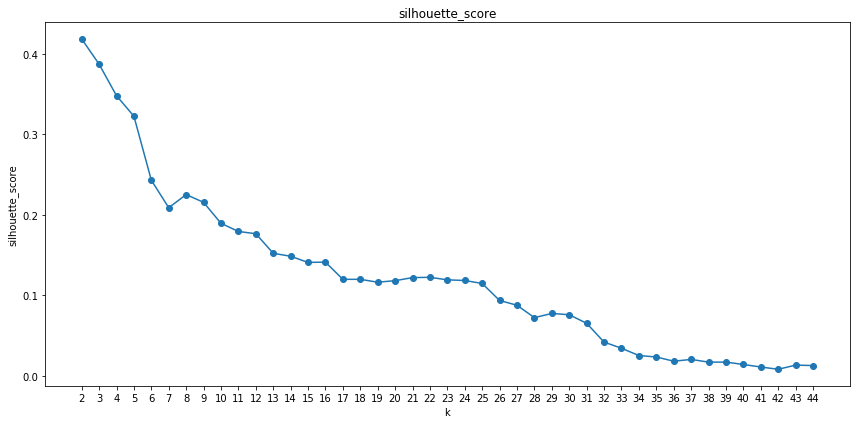

In [119]:
from sklearn.cluster import AgglomerativeClustering

# Best k
Ks=45
silhouette_list_agglomerative_average =  np.zeros((Ks-2))

#Run k-means with different Ks 
for k in range(2,Ks):
    clusterer = AgglomerativeClustering(n_clusters = k, linkage='average').fit(amsterdam_grouped_clustering)    
    silhouette_list_agglomerative_average[k-2] = silhouette_score(amsterdam_grouped_clustering, clusterer.labels_)
    
print(silhouette_list_agglomerative_average)

k= range(2,Ks)

fig = plt.figure()
fig.set_figwidth(12) # set width
fig.set_figheight(6) # set height

plt.plot(k, silhouette_list_agglomerative_average,'o-')
plt.title('silhouette_score')
plt.ylabel('silhouette_score')
plt.xlabel('k')
plt.tight_layout()
plt.xticks(k,k)
plt.show()

Using Agglometative Clustering with linkage *average*, the best silhouette score is 0.41842065 for k=2.

[0.40410746 0.38705653 0.30237911 0.30074726 0.22282822 0.22276503
 0.22081226 0.12587668 0.13748799 0.13639743 0.13915297 0.13700711
 0.09134129 0.08333451 0.08255088 0.07832679 0.07698717 0.07413962
 0.07794767 0.07954705 0.07639048 0.08152195 0.08062412 0.08423113
 0.08054318 0.08018462 0.07796342 0.0734706  0.07578642 0.06514246
 0.02182858 0.02036891 0.02057571 0.02163299 0.02228608 0.01838042
 0.01910321 0.01424449 0.01045619 0.01086655 0.01362574 0.01321662
 0.01266929]


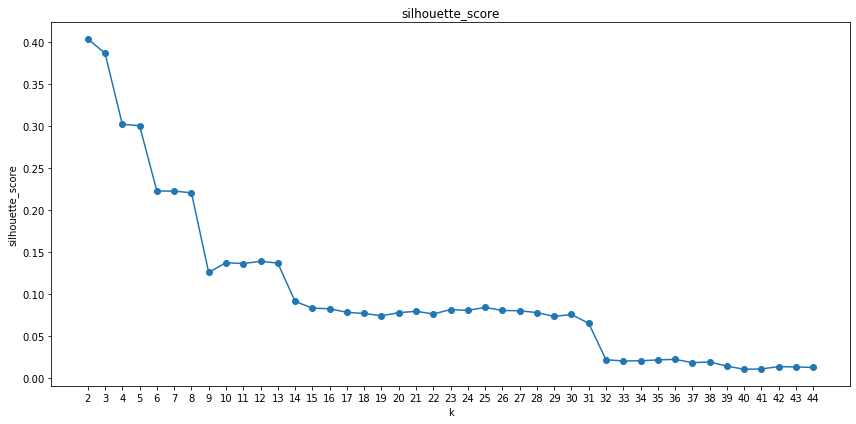

In [120]:
from sklearn.cluster import AgglomerativeClustering

# Best k
Ks=45
silhouette_list_agglomerative_complete =  np.zeros((Ks-2))

#Run k-means with different Ks 
for k in range(2,Ks):
    clusterer = AgglomerativeClustering(n_clusters = k, linkage='complete').fit(amsterdam_grouped_clustering)    
    silhouette_list_agglomerative_complete[k-2] = silhouette_score(amsterdam_grouped_clustering, clusterer.labels_)
    
print(silhouette_list_agglomerative_complete)

k= range(2,Ks)

fig = plt.figure()
fig.set_figwidth(12) # set width
fig.set_figheight(6) # set height

plt.plot(k, silhouette_list_agglomerative_complete,'o-')
plt.title('silhouette_score')
plt.ylabel('silhouette_score')
plt.xlabel('k')
plt.tight_layout()
plt.xticks(k,k)
plt.show()

Using Agglometative Clustering with linkage *complete*, the best silhouette score is 0.40410746 for k=2.

[0.41842065 0.34659545 0.34786053 0.32239178 0.24289875 0.20873767
 0.17478807 0.16829249 0.14060839 0.142766   0.16921868 0.15794748
 0.15875788 0.16391552 0.15797791 0.11913891 0.11984861 0.12395524
 0.11825981 0.11714542 0.1167029  0.11253913 0.11075216 0.11464359
 0.09352866 0.0670862  0.06851158 0.06292033 0.05216479 0.06514246
 0.04900932 0.03212427 0.02512119 0.01810651 0.01279325 0.01611309
 0.01693769 0.01697287 0.01398216 0.00681746 0.00804207 0.01321662
 0.01266929]


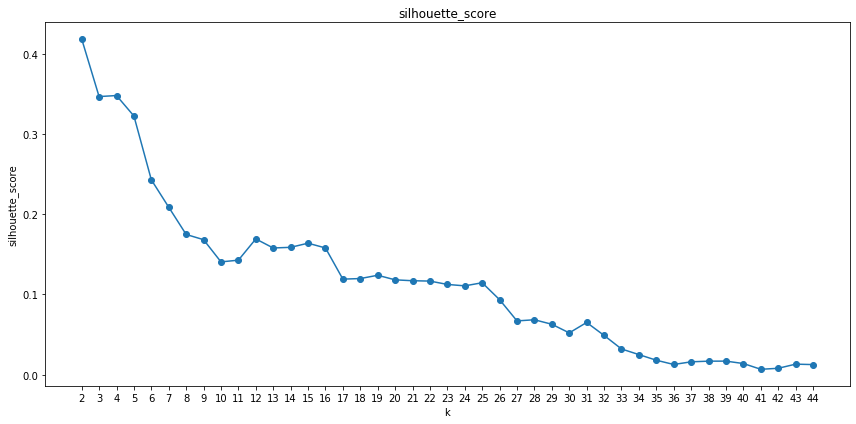

In [121]:
from sklearn.cluster import AgglomerativeClustering

# Best k
Ks=45
silhouette_list_agglomerative_single =  np.zeros((Ks-2))

#Run k-means with different Ks 
for k in range(2,Ks):
    clusterer = AgglomerativeClustering(n_clusters = k, linkage='single').fit(amsterdam_grouped_clustering)    
    silhouette_list_agglomerative_single[k-2] = silhouette_score(amsterdam_grouped_clustering, clusterer.labels_)
    
print(silhouette_list_agglomerative_single)

k= range(2,Ks)

fig = plt.figure()
fig.set_figwidth(12) # set width
fig.set_figheight(6) # set height

plt.plot(k, silhouette_list_agglomerative_single,'o-')
plt.title('silhouette_score')
plt.ylabel('silhouette_score')
plt.xlabel('k')
plt.tight_layout()
plt.xticks(k,k)
plt.show()

Using Agglometative Clustering with linkage *single*, the best silhouette score is 0.41842065 for k=2.

Let's plot all *silhouette_scores* together for a better comprehension. 

In [161]:
data = {'kmeans_elkan': silhouette_list_kmeans_elkan, 
     'kmeans_full': silhouette_list_kmeans_full,
     'agglomerative_ward': silhouette_list_agglomerative_ward,
     'agglomerative_average': silhouette_list_agglomerative_average,
     'agglomerative_complete': silhouette_list_agglomerative_complete,
     'agglomerative_single': silhouette_list_agglomerative_single
    }
k = range(2,Ks)
df = pd.DataFrame(data, index = k) 
df

,kmeans_elkan,kmeans_full,agglomerative_ward,agglomerative_average,agglomerative_complete,agglomerative_single
2,0.214740,0.214740,0.202430,0.418421,0.404107,0.418421
3,0.235843,0.235843,0.215075,0.387057,0.387057,0.346595
4,0.212786,0.212786,0.222535,0.347861,0.302379,0.347861
5,0.194165,0.194165,0.204073,0.322392,0.300747,0.322392
6,0.166204,0.166204,0.209162,0.242899,0.222828,0.242899
7,0.092607,0.092607,0.198944,0.208738,0.222765,0.208738
8,0.097298,0.195993,0.201308,0.225067,0.220812,0.174788
9,0.162949,0.162949,0.137621,0.215413,0.125877,0.168292
10,0.094071,0.094071,0.143727,0.189375,0.137488,0.140608
11,0.060637,0.060637,0.141606,0.179252,0.136397,0.142766


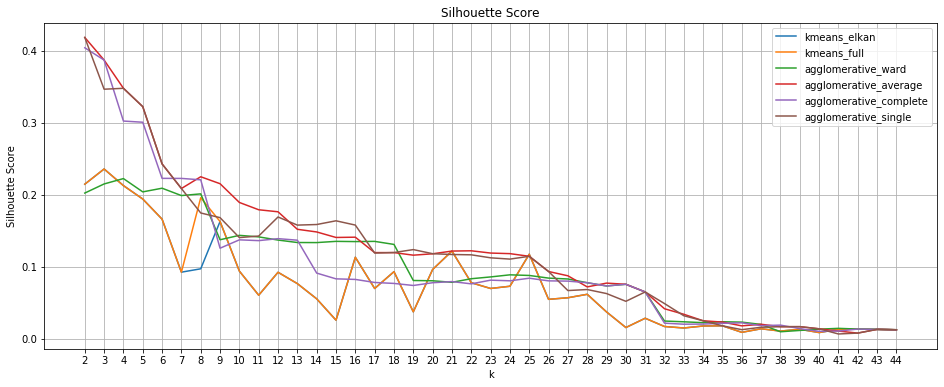

In [162]:
df.plot(kind='line', figsize=(16, 6), xticks=k)
plt.title('Silhouette Score')
plt.ylabel('Silhouette Score')
plt.xlabel('k')
plt.grid()
plt.show()

The image above shows that the best clustering is performed by:  
    - Agglomerative Clustering (linkage average)   -> silhouette score = 0.41842065, k=2  
    - Agglomerative Clustering (linkage single)   -> silhouette score = 0.41842065, k=2    
    - Agglomerative Clustering (linkage complete) -> silhouette score = 0.40410746, k=2    
      

In [88]:
# set number of clusters
kclusters = 2
k_means = AgglomerativeClustering(n_clusters = kclusters, linkage='ward')
# run k-means clustering
k_means.fit(amsterdam_grouped_clustering)

# check cluster labels generated for each row in the dataframe
k_means.labels_

array([2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 0, 1, 2, 2, 2, 1, 0,
       0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2,
       1, 2])

In [89]:
from scipy.spatial import distance_matrix 
dist_matrix = distance_matrix(amsterdam_grouped_clustering,amsterdam_grouped_clustering) 
df = pd.DataFrame(data=dist_matrix)
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,0.446420,0.456211,0.686472,0.463875,0.335159,0.425693,0.374622,0.328226,0.397534,0.327301,0.338874,0.462864,0.321914,0.322392,0.720998,0.526159,0.410973,0.419742,0.384214,0.333690,0.536645,0.643807,0.473676,0.458665,0.340106,0.517708,0.382557,0.347111,0.322144,0.342807,0.327545,0.433460,0.452720,0.345032,0.434245,0.428281,0.485257,0.450981,0.371185,0.344227,0.391529,0.622514,0.454859,0.325478,0.515386,0.351512
std,0.130954,0.102207,0.122014,0.116922,0.140133,0.114309,0.128649,0.140128,0.137335,0.150969,0.146959,0.124093,0.146956,0.148898,0.125353,0.112067,0.116463,0.126295,0.141519,0.148086,0.116761,0.122228,0.105793,0.127851,0.134384,0.114771,0.130204,0.140924,0.151163,0.148399,0.140194,0.127358,0.135146,0.127640,0.118290,0.110567,0.113148,0.104077,0.128212,0.137860,0.126006,0.132537,0.113489,0.143945,0.106750,0.143305
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.368090,0.421092,0.668545,0.411640,0.228763,0.353903,0.288110,0.217402,0.302703,0.207892,0.224855,0.397033,0.204431,0.195294,0.707557,0.483165,0.347619,0.340737,0.279697,0.212920,0.502049,0.606496,0.429902,0.379667,0.240503,0.486549,0.298931,0.234056,0.199680,0.228666,0.217087,0.353338,0.375847,0.251118,0.366274,0.369904,0.430375,0.401138,0.271218,0.236726,0.303085,0.561353,0.397142,0.207543,0.482050,0.247293
50%,0.420530,0.440312,0.689107,0.437766,0.333159,0.408073,0.370486,0.320457,0.366350,0.324113,0.329788,0.430241,0.321426,0.313022,0.720180,0.506804,0.388218,0.395337,0.369219,0.329292,0.529963,0.640727,0.460676,0.458099,0.335008,0.513336,0.374578,0.346892,0.316090,0.318997,0.314952,0.411681,0.422182,0.344855,0.423593,0.414787,0.479418,0.444722,0.358420,0.343356,0.391420,0.613581,0.452316,0.325374,0.506423,0.331468
75%,0.510266,0.494782,0.732401,0.511546,0.401819,0.487811,0.430561,0.397453,0.484979,0.413297,0.415323,0.513124,0.400355,0.409381,0.761796,0.578951,0.448423,0.486801,0.463762,0.412178,0.576982,0.684935,0.512302,0.527322,0.410309,0.569197,0.443781,0.426253,0.409079,0.431814,0.393943,0.484958,0.517418,0.396902,0.480986,0.478406,0.526828,0.477907,0.433226,0.412105,0.455489,0.688060,0.493679,0.405811,0.542567,0.436036
max,0.787401,0.716473,0.879394,0.734847,0.732433,0.728431,0.720555,0.714723,0.761796,0.731853,0.717077,0.800310,0.715044,0.714983,0.912871,0.836660,0.703635,0.774979,0.761796,0.733617,0.768115,0.912871,0.734847,0.758816,0.708908,0.757188,0.763763,0.737781,0.720000,0.736657,0.720278,0.774597,0.799305,0.696091,0.718699,0.707107,0.816497,0.684935,0.712927,0.719623,0.720082,0.912871,0.725062,0.715649,0.746876,0.737394


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


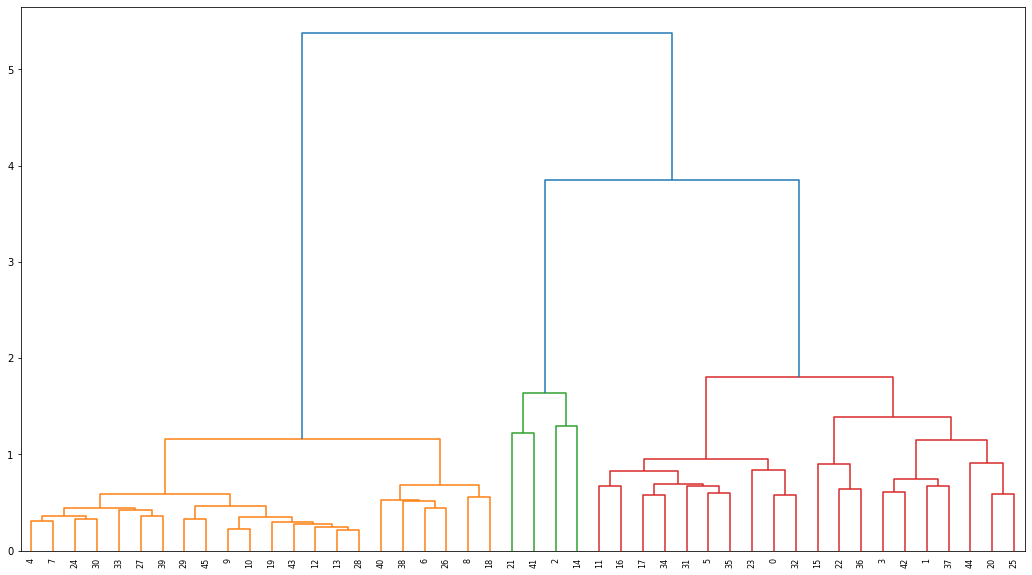

In [78]:
from scipy.cluster import hierarchy 
import pylab

Z = hierarchy.linkage(dist_matrix, 'ward')

fig = pylab.figure(figsize=(18,10))

dendro = hierarchy.dendrogram(Z)

**K_Means with k=9**

In the plot above the elbow is at k=9 indicating the optimal k for this dataset is 9.  
Let's cluster now the neighborhoods in 9 groups. 

In [41]:
*# set number of clusters
kclusters = 9
k_means = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 10, random_state = 0)
# run k-means clustering
k_means.fit(amsterdam_grouped_clustering)

# check cluster labels generated for each row in the dataframe
k_means.labels_

array([4, 8, 7, 0, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 5, 4, 3, 4, 4, 4, 8, 6,
       4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 1, 3, 4,
       3, 4], dtype=int32)

In [90]:
unique, counts = np.unique(k_means.labels_, return_counts=True)
for u, c in zip(unique, counts):
    print ('{}:{}'.format(u,c))

0:5
1:10
2:31


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [91]:
# add clustering labels
neighborhoods_venues_labeled = neighborhoods_venues_sorted.copy()
neighborhoods_venues_labeled.insert(0, 'Cluster Labels', k_means.labels_)

amsterdam_merged = neighborhoods.copy()

# merge neighborhoods_venues_labeled with neighborhoods to add latitude/longitude for each neighborhood
amsterdam_merged = amsterdam_merged.join(neighborhoods_venues_labeled.set_index('Neighborhood'), on='Neighborhood')

amsterdam_merged # check the last columns!

,District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Centre,Centrum-Oost,52.364560,4.906780,2,Bar,Hotel,Café,Restaurant,Coffee Shop,French Restaurant,Pizza Place,Plaza,Bakery,Smoke Shop
1,Centre,Centrum-West,52.373730,4.895691,2,Bar,Hotel,Coffee Shop,Chinese Restaurant,Café,Marijuana Dispensary,Dessert Shop,Burger Joint,Museum,Cocktail Bar
2,West,De Baarsjes,52.368926,4.856382,2,Café,Bar,Coffee Shop,Restaurant,Tram Station,Snack Place,Supermarket,Wine Shop,Food & Drink Shop,Ramen Restaurant
3,West,Oud-West,52.364815,4.869762,2,Café,Coffee Shop,Italian Restaurant,Bar,Restaurant,Indonesian Restaurant,Movie Theater,Moroccan Restaurant,Modern European Restaurant,Dutch Restaurant
4,West,Westerpark,52.387236,4.871777,2,Nightclub,Bar,Restaurant,Italian Restaurant,Coffee Shop,Café,BBQ Joint,Ice Cream Shop,Snack Place,Brewery
5,West,Bos en Lommer,52.378521,4.848738,2,Bakery,Restaurant,Vegetarian / Vegan Restaurant,Park,Fast Food Restaurant,Food & Drink Shop,Turkish Restaurant,Supermarket,Playground,Pizza Place
6,Nieuw-West,Geuzenveld,52.378394,4.801628,1,Supermarket,Bus Stop,Grocery Store,Tram Station,Italian Restaurant,Drugstore,Plaza,Market,Turkish Restaurant,Smoke Shop
7,Nieuw-West,Slotermeer,52.377961,4.821952,2,Turkish Restaurant,Supermarket,Café,Dessert Shop,Discount Store,Bus Stop,Coffee Shop,Snack Place,Liquor Store,Food Truck
8,Nieuw-West,Sloterdijken,52.387100,4.846500,2,Hotel,Restaurant,Garden,Italian Restaurant,Casino,IT Services,Plaza,Hostel,Supermarket,None
9,Nieuw-West,Slotervaart,52.361286,4.827466,2,Asian Restaurant,Bakery,Bus Stop,Martial Arts Dojo,Steakhouse,Soccer Field,Food Service,Italian Restaurant,Moroccan Restaurant,Indian Chinese Restaurant


In [92]:
amsterdam_merged['Cluster Labels'].value_counts()

2    31
1    10
0     5
Name: Cluster Labels, dtype: int64

Finally, let's visualize the resulting clusters

In [93]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(amsterdam_merged['Latitude'], amsterdam_merged['Longitude'], amsterdam_merged['Neighborhood'], amsterdam_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item4'></a>

## 4. Results

## 4.1. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. We will start counting from **Cluster 0**. I will leave this exercise to you.

#### Cluster 0

In [94]:
amsterdam_merged.loc[amsterdam_merged['Cluster Labels'] == 0, amsterdam_merged.columns[[1] + list(range(5, amsterdam_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Nieuw-Sloten,Harbor / Marina,Wine Shop,Beach,Boat or Ferry,None,None,None,None,None,None
28,Nieuwendammerdijk,Indonesian Restaurant,Snack Place,Harbor / Marina,Bar,Bus Stop,Tennis Court,None,None,None,None
33,Tuindorp Nieuwendam,Snack Place,Harbor / Marina,Smoke Shop,Park,Indonesian Restaurant,Plaza,None,None,None,None
37,Bijlmer-Centrum,Park,Bus Stop,Theater,None,None,None,None,None,None,None
39,Gaasperdam Driemond,Nightclub,Harbor / Marina,Playground,Park,Farm,None,None,None,None,None


Cluster 1

In [95]:
amsterdam_merged.loc[amsterdam_merged['Cluster Labels'] == 1, amsterdam_merged.columns[[1] + list(range(5, amsterdam_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Geuzenveld,Supermarket,Bus Stop,Grocery Store,Tram Station,Italian Restaurant,Drugstore,Plaza,Market,Turkish Restaurant,Smoke Shop
10,De Aker,Tram Station,Snack Place,Pizza Place,Fish & Chips Shop,Supermarket,Cheese Shop,Bakery,Drugstore,Pharmacy,None
19,Banne Buiksloot,Bus Stop,Park,Shopping Mall,Bakery,Restaurant,Supermarket,Turkish Restaurant,None,None,None
20,Kadoelen,Shopping Mall,Bus Stop,Supermarket,Furniture / Home Store,None,None,None,None,None,None
21,Oostzanerwerf,Bus Stop,Supermarket,Pharmacy,Shopping Mall,Gym / Fitness Center,Bookstore,None,None,None,None
22,Tuindorp Oostzaan,Bus Stop,Snack Place,Plaza,Shop & Service,Business Service,Motorcycle Shop,Theater,Baseball Field,None,None
24,Elzenhagen,Bus Stop,Clothing Store,None,None,None,None,None,None,None,None
26,Waterlandpleinbuurt,Supermarket,Concert Hall,Bus Stop,Discount Store,Grocery Store,Indonesian Restaurant,Fried Chicken Joint,None,None,None
38,Bijlmer-Oost,Shopping Mall,Supermarket,Bus Stop,Bakery,Discount Store,Drugstore,None,None,None,None
42,Zeeburgereiland,Bus Stop,Tram Station,Snack Place,Café,Rock Club,None,None,None,None,None


Cluster 2

In [96]:
amsterdam_merged.loc[amsterdam_merged['Cluster Labels'] == 2, amsterdam_merged.columns[[1] + list(range(5, amsterdam_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Centrum-Oost,Bar,Hotel,Café,Restaurant,Coffee Shop,French Restaurant,Pizza Place,Plaza,Bakery,Smoke Shop
1,Centrum-West,Bar,Hotel,Coffee Shop,Chinese Restaurant,Café,Marijuana Dispensary,Dessert Shop,Burger Joint,Museum,Cocktail Bar
2,De Baarsjes,Café,Bar,Coffee Shop,Restaurant,Tram Station,Snack Place,Supermarket,Wine Shop,Food & Drink Shop,Ramen Restaurant
3,Oud-West,Café,Coffee Shop,Italian Restaurant,Bar,Restaurant,Indonesian Restaurant,Movie Theater,Moroccan Restaurant,Modern European Restaurant,Dutch Restaurant
4,Westerpark,Nightclub,Bar,Restaurant,Italian Restaurant,Coffee Shop,Café,BBQ Joint,Ice Cream Shop,Snack Place,Brewery
5,Bos en Lommer,Bakery,Restaurant,Vegetarian / Vegan Restaurant,Park,Fast Food Restaurant,Food & Drink Shop,Turkish Restaurant,Supermarket,Playground,Pizza Place
7,Slotermeer,Turkish Restaurant,Supermarket,Café,Dessert Shop,Discount Store,Bus Stop,Coffee Shop,Snack Place,Liquor Store,Food Truck
8,Sloterdijken,Hotel,Restaurant,Garden,Italian Restaurant,Casino,IT Services,Plaza,Hostel,Supermarket,None
9,Slotervaart,Asian Restaurant,Bakery,Bus Stop,Martial Arts Dojo,Steakhouse,Soccer Field,Food Service,Italian Restaurant,Moroccan Restaurant,Indian Chinese Restaurant
11,Sloten,Hockey Field,Ice Cream Shop,Comedy Club,Playground,Pub,Restaurant,Monument / Landmark,Middle Eastern Restaurant,Football Stadium,Snack Place


Cluster 3

In [97]:
amsterdam_merged.loc[amsterdam_merged['Cluster Labels'] == 3, amsterdam_merged.columns[[1] + list(range(5, amsterdam_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


Cluster 4

In [98]:
amsterdam_merged.loc[amsterdam_merged['Cluster Labels'] == 4, amsterdam_merged.columns[[1] + list(range(5, amsterdam_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


<a id='item5'></a>

## 5. Discussion

<a id='item6'></a>

## 6. Conclusion